# Multivariate time series forecasting using 1D convolution  
**Authors:** Konrad Maciejczyk (276927), Robert Walery (249000), Katarzyna Czak (254752)  
Wrocław University of Science and Technology, 2023-2024  

**Dataset:** [Stock Exchange Data](https://www.kaggle.com/code/alexisbcook/deep-reinforcement-learning)  

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

2024-01-19 21:44:48.964335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 21:44:48.996737: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 21:44:48.997762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 21:44:49.500770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data loading and preprocessing

In [3]:
stock_df = pd.read_csv('indexData.csv')
stock_NYA_df = stock_df[stock_df['Index'] == 'NYA'].dropna()
dates = stock_NYA_df['Date']
stock_NYA_df.drop(['Index', 'Date', 'Volume'], axis='columns', inplace=True)
stock_NYA_df

,Open,High,Low,Close,Adj Close
0,528.690002,528.690002,528.690002,528.690002,528.690002
1,527.210022,527.210022,527.210022,527.210022,527.210022
2,527.840027,527.840027,527.840027,527.840027,527.840027
3,531.119995,531.119995,531.119995,531.119995,531.119995
4,532.070007,532.070007,532.070007,532.070007,532.070007
...,...,...,...,...,...
13943,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450
13944,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450
13945,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940
13946,16451.960940,16546.359380,16451.960940,16531.949220,16531.949220


In [4]:
stock_NYA_df = stock_NYA_df['Adj Close']
stock_NYA_df=(stock_NYA_df-stock_NYA_df.mean())/stock_NYA_df.std()

In [5]:
WINDOW_SIZE = 10
#FEATURE_SIZE = stock_NYA_df.shape[1]
FEATURE_SIZE = 1

def df_to_X_y(df, window_size = 6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
X, y = df_to_X_y(stock_NYA_df, window_size = WINDOW_SIZE)
X.shape, y.shape

((13937, 10), (13937,))

## Splitting data into training, validating and testing datasets

In [7]:
train_len = int(stock_NYA_df.shape[0] * 0.6)
test_val_len = int(stock_NYA_df.shape[0] * 0.2)

X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len: train_len + test_val_len], y[train_len: train_len + test_val_len]
X_test, y_test = X[train_len + test_val_len: train_len + (test_val_len * 2)], y[train_len + test_val_len: train_len + (test_val_len * 2)]

print(f'Training dataset size: {X_train.shape}')
print(f'Testing dataset size: {X_test.shape}')
print(f'Validation dataset size: {X_val.shape}')

Training dataset size: (8368, 10)
Testing dataset size: (2780, 10)
Validation dataset size: (2789, 10)


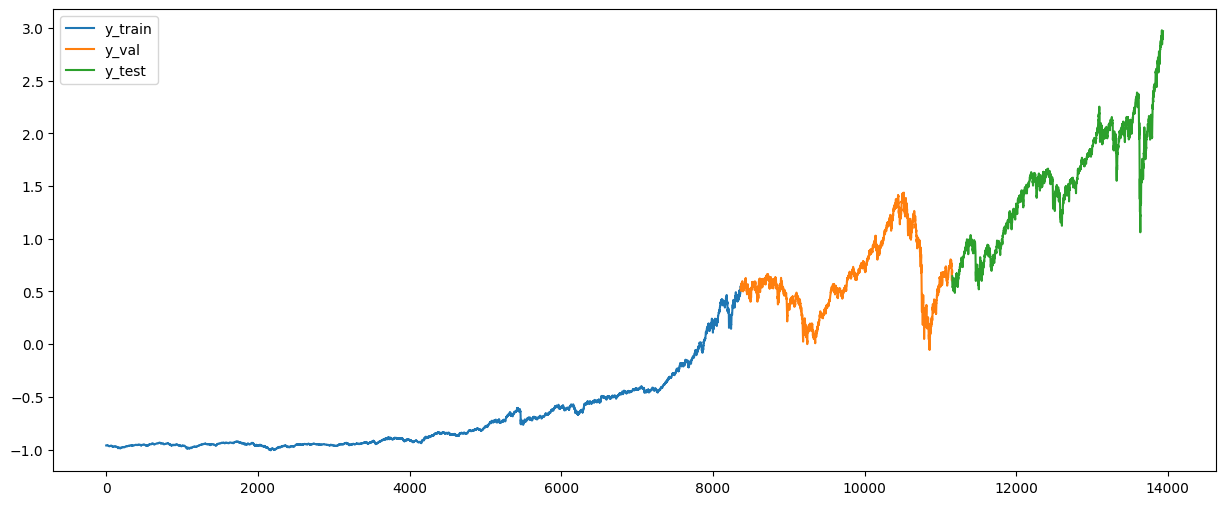

In [8]:
plt.figure(figsize=(15, 6))
a = y_train.shape[0]
plt.plot([_ for _ in range(a)], y_train, label = 'y_train')
a, b= y_train.shape[0], y_train.shape[0] + y_val.shape[0]
plt.plot([_ for _ in range(a, b)], y_val, label = 'y_val')
a, b = y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]
plt.plot([_ for _ in range(a, b)], y_test, label = 'y_test')
plt.legend()
plt.show()

## Model architecture  

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((WINDOW_SIZE, FEATURE_SIZE)))
model.add(tf.keras.layers.Conv1D(64, kernel_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, 'relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             192       
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 8)                 4616      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,817
Trainable params: 4,817
Non-trainable params: 0
_________________________________________________________________


2024-01-19 21:44:56.075693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-19 21:44:56.076040: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [11]:
EPOCHS = 100
BATCH_SIZE = 128

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose = 0)

## Model evaluation

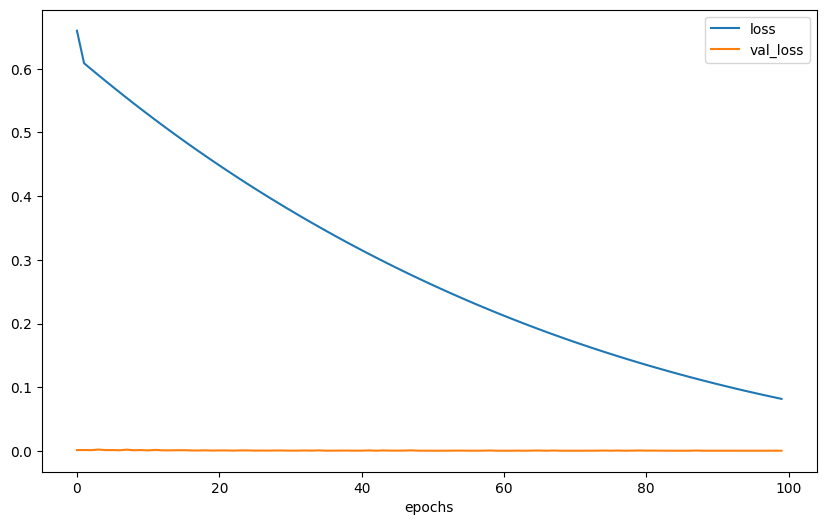

In [12]:
plt.figure(figsize=(10, 6))
plt.plot([_ for _ in range(EPOCHS)], history.history['loss'], label = 'loss')
plt.plot([_ for _ in range(EPOCHS)], history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

### Predicting on test data 

In [13]:
pred = model.predict(X_test)

87/87 [==============================] - 0s 688us/step


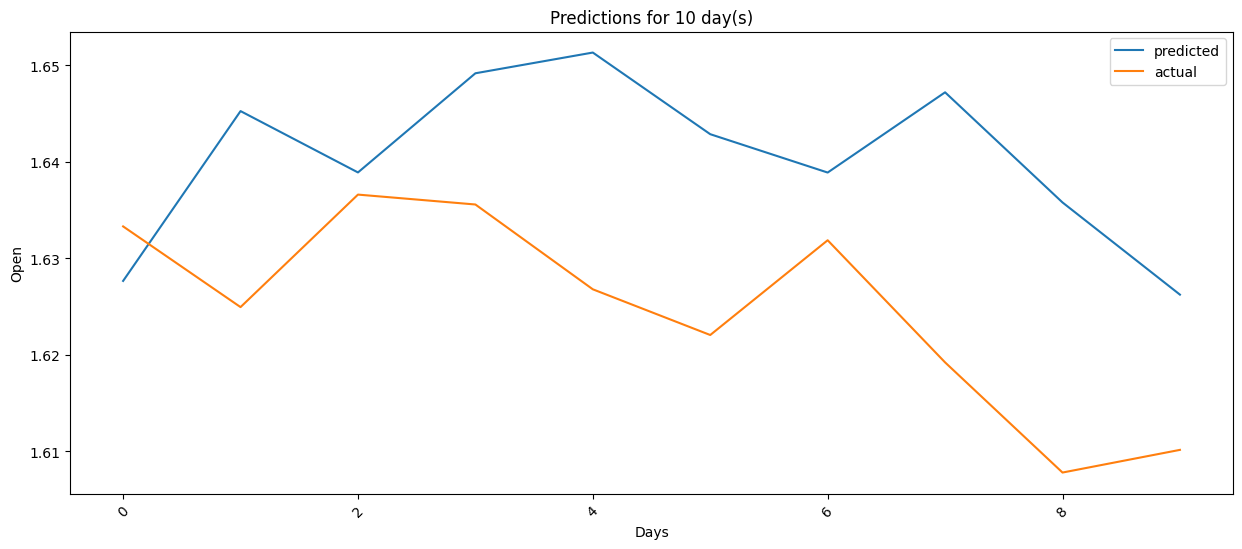

In [14]:
SLICE_START = 1200 #plot begin point
SLICE_LEN = 10 #predictions amount

a = y_train.shape[0] + y_val.shape[0]
x = dates[a + SLICE_START: a + SLICE_START + SLICE_LEN].to_numpy()
x.reshape(((len(x), 1)))

x = range(SLICE_LEN) #comment this to see dates on x axis

plt.figure(figsize=(15, 6))
plt.plot(x, pred[SLICE_START: SLICE_START + SLICE_LEN], label='predicted')
plt.plot(x, y_test[SLICE_START:SLICE_START + SLICE_LEN], label = 'actual')
plt.xlabel('Days')
plt.ylabel('Open')
plt.title(f'Predictions for {SLICE_LEN} day(s)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [14]:
print('Mean absolute error (predictions - actuals): {:.2f}'.format(mean_absolute_error(y_test, pred)))

Mean absolute error (predictions - actuals): 0.26
